# Project 3: Zombies and Covid-19
## Trust the models, or your gut? 
### MOD510 - University of Stavanger
### Aleksander B. Jakobsen & Anne H. Amundsen
#### 15. November 2020

### Abstract

In this project we have learned how to implement solvers for systems of first-order ordinary differential equations (ODEs) in Python. 

In the first exercise we create a general ODE solver class where we implement the Forward Euler and Runge Kutta fourth order schemes, both of which are explicit. These are then tested on a second-order differential equation and compared to the analytical solution. We find that the Forward Euler scheme requires a much smaller time step to be accurate than the Runge Kutta 4th order scheme.

In exercise 2 we implement the SZ-model, which is a compartment model consisting of two compartments, Susceptible humans and Zombies. Differential equations are set out to describe how individuals "flow" from one compartment to another. This model is tested on the populations of Dirdal and Sokndal with one initial infected person in each village. At first we use a constant infection rate, $\beta$, and we see that the entire population eventually gets turned into zombies. As the zombie outbreak evolves, people become more aware and not as easily fooled by the zombies, we therefore model the infection rate as a function of time. We then see that some humans will be able to survive the outbreak.

The SZ-model is expanded to a 4-compartment model in exercise 3, namely the SEZR-model, where we add two more compartments: <br>
E: Exposed humans <br>
R: Removed Zombies <br>
We also implement an attack function to model organised attacks by humans on the zombies. Here we find that if we do not have organised attacks, it is impossible to survive the zombie apocalypse if the infection rate is larger than the  average rate of zombie killing. Turning on violent attacks helps the humans survive, however, unless they are frequent and strong, it mostly just delays the inevitable doom. 

In exercise 4, the model is further expanded to a 5-compartment model and the zombie-compartment is changed to an infectious compartment to instead model the spread of Covid-19. The additional compartment added is D for dead individuals and R is now the number of recovered individuals. In this exercise we import actual Covid-19 data from several countries and compare the no. of confirmed cases and deaths. We then try to fit parameters in the numerical model to the actual data. We use the Hubei province in China as a staring point to create the parameters. We get a good curve fit to this data, however we see that the parameters in Hubei can not be used for the other countries we tested as China's response to Covid-19 have been different than the other countries we tested and they have few cases compared to the large population. In addition, Hubei has not had a second wave of Covid-19 like we can see in most other countries. We then tune the models individally to Norway, Sweden, UK and USA to get a better match to the data. 

Our results show that using the theoretical equations and numerical solvers we can get a good correlation between the experimental data and the numerical data. The Runge Kutta 4th order method gives more accurate results than the Forward Euler with a larger time step and therefore we have used this method in Exercises 3 and 4.

### Introduction

In mathematics, an ordinary differential equation (ODE) is a differential equation containing one or more functions of one independent variable, often time, and the derivatives of those functions. Not to be confused with partial differentional equations (PDE) which describes a system that may evolve in more than dimension \[1]. 

The Euler method (also called the Forward Euler method) is a first-order numerical procedure for solving ordinary differential equations with a given initial value and it is one of the simplest explicit methods for numerical integration of ODEs. The Euler method is a first-order method, which means that the local error is proportional to the square of the step size and the global error is proportional to the step size. The method is often used on its own or as a basis to construct more complex methods. A more complex numerical method is the Runge-Kutta 4th order method. As the name suggests, this is accurate to $h^4$, has a local error proportional to $h^5$, where $h$ is the step size. It is one of the most used methods for solving complex ordinary differential equations. 

Compartment models \[8\] are widely used to study how an epidemic disease might spread in a population. In these models, the population is partitioned based on a set of possible "disease states", and the ordinary differential equations are set up to describe how individuals "flow" from one compartment to another. These compartment models can be used to predict the outcome of a zombie apocalypse or the spread of the Covid-19 pandemic. These models can further be used to investigate what the best strategies are for conquering the zombies or viruses. 

The Covid-19 outbreak started in the Hubei province in China in late 2019. The virus then spread to nearby countries and arrived in Europe in January 2020. The outbreak was first classified as an epidemic before it was upgraded to a pandemic 11. March 2020 \[9\] and the next day Norway introduced the strictest restrictive measures since the 2nd World War in Norway. Several other countries followed with lockdowns and travel restrictions which led to the countries being able to slow the infections spread to a point where they were able to open up again. This lasted for a few months until the fall of 2020 when the spread is rapidly rising again and several countries again have to introduce lockdowns and restrictions. 

This project investigates the use of mathematical models using ordinary differential equations to describe real-life or fictional problems. The models are used to see whether we can escape a zombie invasion and describe the spread of the Corona virus. The models are then compared with actual data on the Covid-19 confirmed cases and deaths.


In [3]:
#Import packages/libraries needed for the exercise. 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
plt.style.use("seaborn")

### Exercise 1: General ODE solver

The goal of this exercise is to implement a ODE solver that can handle any system of ordinary differential equations (ODEs) of the form 

$$
\begin{align}
\frac{d\vec{y}}{dt} &= \vec{f}(\vec{y}, t) \,, \\ 
\vec{y}(0) &= \vec{y_0} \,,
\end{align}
$$

where $t\geq{0}$ is a real number, $ \vec{y(t)}$ is the unknown solution
vector with initial condition $ \vec{y_0} $,
and $ \vec{f} $ is a vector-valued function that can depend upon
both $ y $ and $ t $.


#### Part 1:
In this part, we wish to implement ODE solver based in the Forward Euler scheme and the 4th order Runge Kutta Scheme.

The Forward Euler scheme is shown below:

\begin{equation}
   y_{n+1} = y_{n} + hf(y_n,t_n) 
\end{equation}

where $\mathbf{y}_n$ is the current step, $\mathbf{y}_{n+1}$ is the next step, $h$ is the step size and $\mathbf{f}(\mathbf{y},t)$ is the function from (1).

The 4th order Runge Kutta scheme:

\begin{align}
   & k_1 = h f(y_n,t_n) \\
   & k_2 = h f(y_n +\frac{1}{2}k_1,t_n + \frac{h}{2}) \\
   & k_3 = h f(y_n +\frac{1}{2}k_2,t_n + \frac{h}{2}) \\
   & k_4 = h f(y_n +k_3,t_n + h) \\
   & y_{n+1} = y_{n} + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{align}



ODE solvers using Forward Euler and Runge Kutta are implemented as subclasses in the ODESolver class, below:

In [4]:


class ODESolver:
    """
    Base class for ODE solvers.
    Subclasses of this class will implement a particular numerical
    scheme for solving a system of first-order ODEs of the form

        dY/dt = f(Y, t), Y(0)=Y0,

    where Y=Y(t) can be either a function of a single real-valued
    variable, or a vector of such functions.

    Note that the current implementation presumes a constant step
    size for the integration. 
    """

    def __init__(self,f,y0,dt):
        """
        :param f: The right-hand side function of the ODE (system).
        :param y0: The initial condition.
        :paran dt: Constant step-size. 
        """

        # Trick: Ensure that f will return an array even if the
        # user returns a list
        self.f_ = lambda y, t, **kwargs: np.array(f(y, t,**kwargs), dtype='float')
        self.y0_ = y0
        self.dt_ = dt

        # Set simulation history to "None" before initializing
        self.t_ = None
        self.y_ = None

    def reset_model(self):
        """
        Resets the model before starting up a new simulation.
        """
        self.t_ = [0]
        self.y_ = [self.y0_]

    def solve(self, max_t, verbose=0,**kwargs):
        """
        Calls the reset model function, and further advance function to solve ODE with chosen solver method. 
        """
        self.reset_model()
        no_steps = int(max_t / self.dt_)
        current_t = 0
        dt = self.dt_
        for _ in range(no_steps):
            self.advance(dt,**kwargs)
            current_t += dt
            if verbose:
                msg = 'Done computing solution at'
                msg += ' t={}.'.format(current_t)
                print(msg)
        return np.array(self.t_), np.array(self.y_)

    def advance(self, dt,**kwargs):
        """
        Raises error if advance is called on base class ODESolver. 
        """
        err = "advance() cannot be called on base class ODESolver."
        err += " Must call on an instance of an ODESolver subclass!"
        raise NotImplementedError(err)

class ForwardEuler(ODESolver):
    """
    Subclass for solving ODEs using Forward Eulers method. 
    """

    def __init__(self, f, y0, dt):
        super().__init__(f, y0, dt)  # call superclass __init__ method

    def advance(self, dt,**kwargs):
        """
        Integrates function f from time t to t+dt using Forward Euler.
        tn = current time
        dt = step size
        yn = solution vector
        """
        tn, yn = self.t_[-1], self.y_[-1]
        f = self.f_
        self.t_.append(tn+dt)
        self.y_.append(yn + dt*f(yn, tn,**kwargs))



        

class RungeKutta(ODESolver):
    """
    Subclass for solving ODEs using 4th order Runge Kutta method. 
    """
    def __init__(self, f, y0, dt):
        super().__init__(f, y0, dt)  # call superclass __init__ method

    def advance(self, dt,**kwargs):
        """
        Integrates function f from time t to t+dt using Runge Kutta.
        tn = current time
        dt = step size
        yn = solution vector
        """
        tn, yn = self.t_[-1], self.y_[-1]
        f = self.f_
        k1 = dt*f(yn,tn,**kwargs)
        k2 = dt*f(yn+k1*0.5,tn+0.5*dt,**kwargs)
        k3 = dt*f(yn+0.5*k2,tn+0.5*dt,**kwargs)
        k4 = dt*f(yn+k3,tn+dt,**kwargs)
        self.t_.append(tn+dt)
        self.y_.append(yn+(k1+2*k2+2*k3+k4)/6)




#### Part 2:


We consider the second order differential equation below:

\begin{equation}
   x^{\prime\prime}(t) + \omega^2x(t) = 0
\end{equation}

where $x_0 = x(0)$ and $v_0 = x^\prime(0)$.

The analytical solution is:
\begin{equation}
   x(t) = x_0 \cdot cos(\omega t) + \frac{v_0}{\omega}\cdot sin(\omega t)
\end{equation}


Function to solve analytical solution:

Text(0, 0.5, 'x')

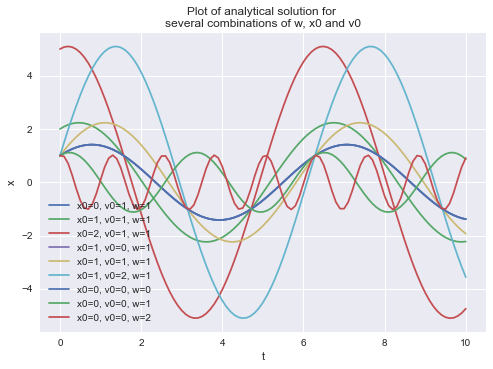

In [5]:
def analytical_x(t,x0,v0,w,): #Analytcal solution
    return x0*np.cos(w*t) + (v0/w)*np.sin(w*t)

#Solve the function for various combinations of values

t = np.linspace(0,10,101)
various_x0 = [1,2,5]
varios_v0 = [1,2,5]
various_w = [1,2,5]

for i in range(3):
    y = analytical_x(t,various_x0[i],1,1)
    plt.plot(t,y,label="x0="+str(i)+", v0=1, w=1")

for i in range(3):
    y = analytical_x(t,1,varios_v0[i],1)
    plt.plot(t,y,label="x0=1, v0="+str(i)+", w=1")

for i in range(3):
    y = analytical_x(t,1,1,various_w[i])
    plt.plot(t,y,label="x0=0, v0=0, w="+str(i))
plt.legend()
plt.title("Plot of analytical solution for \nseveral combinations of w, x0 and v0")
plt.xlabel("t")
plt.ylabel("x")



#### Part 3

As Equtaion (3) is a second order ODE and not in the required from, this has been converted to a system of first order equations by introducing a new variable $v = v(t) = x^\prime(t)$ and let:

$$
\vec{y}=
\begin{pmatrix}
x \\ 
v \\ 
\end{pmatrix}\,.
$$

Then we get Equation (5) on the form (1):

$$
\begin{align}
\frac{d\vec{y}}{dt} &=
\begin{pmatrix}
v \\ 
-\omega^2 x \\ 
\end{pmatrix} \,.
\end{align}
$$

In the next part we let $\omega = 1$, $x_0 = 1$ amd $v_0 = 0$

In [6]:
#Function as described in problem formulation
def f(y,t):
    return np.array([y[1],-w**2*y[0]])


Text(0.5, 1.0, 'Comparison of analytical and numerical solution \nfor time step = 0.1')

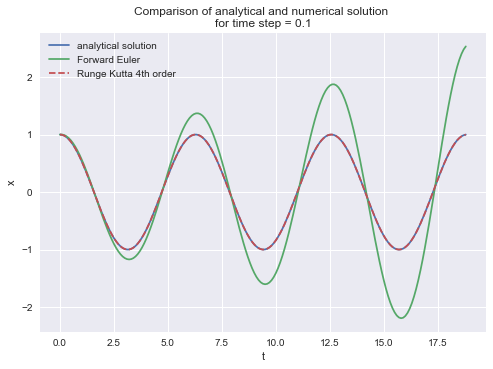

In [7]:
# Constants
x0 = 1
v0 = 0
w = 1

# input parameters
dt = 0.1 # time step
y0 = np.array([x0,v0]) # initial condition
P = 2*np.pi/w
max_t = 3*P # max simulation time

# numerical solution
FwEuler_sol = ForwardEuler(f=f,y0=y0,dt=dt) # initiate Forward Euler
t_fe, y_fe = FwEuler_sol.solve(max_t=max_t) # solve Forward Euler
RK_sol = RungeKutta(f=f,y0=y0,dt=dt) # initiate Runge Kutta
t_rk, y_rk = RK_sol.solve(max_t=max_t) # solve Runge Kutta

#analytical solution
t = np.arange(0,max_t,dt)
xt = analytical_x(t, x0=x0, v0=v0, w=w)

# plot solutions:
plt.plot(t,xt, label='analytical solution')
plt.plot(t_fe, y_fe[:,0], label='Forward Euler')
plt.plot(t_rk, y_rk[:,0],'--' ,label='Runge Kutta 4th order')
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.title(f'Comparison of analytical and numerical solution \nfor time step = {dt}')

We see that the Forward Euler starts to diverge from the analytical solution. The 4th order Runge Kutta accuracy order of $h^4$, while the Forward Eulers has a accuracy order of $h$ \[1].

Below, we compare the solvers with step size 0.01

Text(0.5, 1.0, 'Comparison of analytical and numerical solution \nfor time step = 0.01')

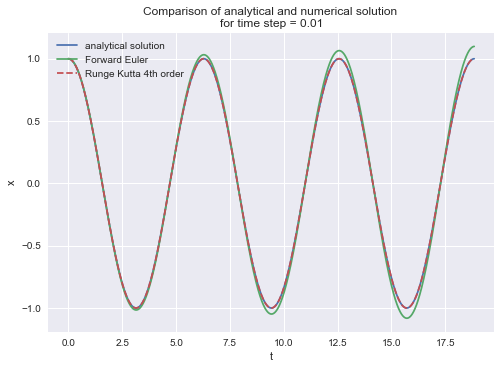

In [8]:
dt = 0.01 # time step changed, all other parameters as previous plot

# numerical solution
FwEuler_sol = ForwardEuler(f=f,y0=y0,dt=dt) # initiate Forward Euler
t_fe, y_fe = FwEuler_sol.solve(max_t=max_t) # solve Forward Euler
RK_sol = RungeKutta(f=f,y0=y0,dt=dt) # initiate Runge Kutta
t_rk, y_rk = RK_sol.solve(max_t=max_t) # solve Runge Kutta

#analytical solution
t = np.arange(0,max_t,dt)
xt = analytical_x(t, x0=x0, v0=v0, w=w)

# plot solutions:
plt.plot(t,xt, label='analytical solution')
plt.plot(t_fe, y_fe[:,0], label='Forward Euler')
plt.plot(t_rk, y_rk[:,0],'--' ,label='Runge Kutta 4th order')
plt.legend()
plt.xlabel('t')
plt.ylabel('x')
plt.title(f'Comparison of analytical and numerical solution \nfor time step = {dt}')

We see that by reducing the time step by a factor of 10, the Forward Euler method still diverges from analytical solution. We also study the runtime of the two solvers. We do this for both the timesteps above, 0.1 and 0.01: 

In [9]:
#Timestep 0.1
dt = 0.1 
# numerical solution
%timeit ForwardEuler(f=f,y0=y0,dt=dt).solve(max_t=max_t) #Time check forward euler
%timeit RungeKutta(f=f,y0=y0,dt=dt).solve(max_t=max_t) #Time check forward euler



989 µs ± 8.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.37 ms ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We see that the Forward Euler method performs a factor of approximately 5 times faster than the Runge Kutta method. However, since the Forward Euler does not perform well with time step 0.1, we investigate the runtime with time step 0.01:
 

In [10]:
dt = 0.01
%timeit ForwardEuler(f=f,y0=y0,dt=dt).solve(max_t=max_t) #Time check forward euler
%timeit RungeKutta(f=f,y0=y0,dt=dt).solve(max_t=max_t) #Time check runge kutta

9.93 ms ± 65.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.9 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We see that the runtime between the Forward Euler and Runge Kutta is approximately a factor of 5 in favor of the Forward Euler when comparing runtime with a time step 0.01. However, since we are interested in model accuracy, the Runge Kutta is our method of choice, even when considering runtime. Runge Kutta also reduces runtime since it allows us to use a larger time step and still acheive a better accuracy compared to the Forward Euler. 

### Exercise 2: No hope? 

Compartement models are widely used to study how an epidemic disease might spread in a population. In such models, the population is divided into compartements based on a set of disease states. Differential equations are used to describe how indivuduals move from one compartement to another. 

We wish to study a compartement models describing a zombie outbreak. The first model we start to study is the SZ-model, which consists of two compartements:

S -Suceptible: humans that risk beeing turned into zombies; by being bitten or scratched by a zombie.
Z- Zombies.







We have the following ODE's for number of suceptible humans (S) and number of zombies (Z) from the project description, Ref. \[2].
\begin{align}
   &\frac{dS(t)}{dt} = -\beta \cdot \frac{S(t)Z(t)}{N},\\
   &\frac{dZ(t)}{dt} = +\beta \cdot \frac{S(t)Z(t)}{N},
\end{align}
where $S(t)$ is number of humans (susceptible), $Z(t)$ is number of zombies, $\beta$ is the zombie infection rate, and $N$ the total population size.





#### Part 1:
We wish to find the analytical solution to the SZ-model. The analytical solution to the SZ-model given in the equations above can be found by rearranging $\frac{dS(t)}{dt}$ for dS and dt and using the fact that $N = S(t) + Z(t)$ at a given time $t$.

\begin{equation}
   \frac{N}{S(N-S)} dS = -\beta dt
\end{equation}

Then we integrate each side:
\begin{equation}
   \int \frac{N}{S(N-S)} dS = \int -\beta dt
\end{equation}

Resulting in:
\begin{equation}
   log \left(\frac{S}{S-N}\right)= -\beta t + C
\end{equation}

Taking the exponent on each side and updating the constant $C$ to: $C^* = e^C$:

\begin{equation}
   \frac{S}{S-N}= e^{-\beta t} \cdot C^*
\end{equation}

We know that $N = S_0 + Z_0$, we can then insert the boundary conditions $S(0) = S_0$ and $Z(0) = Z_0$ to find $C^*$:

\begin{align}
   &\frac{S_0}{S_0-(S_0+Z_0)}= e^{-\beta \cdot 0} \cdot C^* \\
   & C^* = \frac{S_0}{S_0-(S_0+Z_0)} = -\frac{S_0}{Z_0}
\end{align}

Inserting this above gives:
\begin{equation}
   \frac{S}{S-N}= -\frac{S_0}{Z_0}e^{-\beta t}
\end{equation}

Rearranging gives the analytical solution for S(t):
\begin{equation}
   S(t)= \frac{(S_0+Z_0)\frac{S_0}{Z_0}e^{-\beta t}}{1+\frac{S_0}{Z_0}e^{-\beta t}}
\end{equation}




For $Z$, we start by using the relation
\begin{equation}
    S = N - Z = S_0 + Z_0 - Z,
\end{equation}
which can be written as
\begin{equation}
    S_0 + Z_0 - Z = \frac{(S_0+Z_0)\frac{S_0}{Z_0}e^{-\beta t}}{1+\frac{S_0}{Z_0}e^{-\beta t}}
\end{equation}
Therefore, $Z$ can be found by
\begin{equation}
    Z = \frac{(S_0+Z_0) (1+ \frac{S_0}{Z_0}e^{-\beta t})}{1+\frac{S_0}{Z_0}e^{-\beta t}} - \frac{(S_0+Z_0)\frac{S_0}{Z_0}e^{-\beta t}}{1+\frac{S_0}{Z_0}e^{-\beta t}},
\end{equation}
which yields
\begin{equation}
   Z(t) = \frac{S_0+Z_0}{1+\frac{S_0}{Z_0}e^{-\beta t}}  .
\end{equation}



#### Part 2:
The SZ- predicts that the entire human population will be turned into zombies as $\lim_{t \to \infty}$. This can be proved by evaluation the experssions for $S$ and $Z$ as  $\lim_{t \to \infty}$.

Firstly, we can see that the enitre population turn into zombies by:

$$
\begin{align}
\lim_{t \to \infty} Z(t) = \lim_{t \to \infty} Z(t) &= \lim_{t \to \infty} \frac{S_0+Z_0}{1+\frac{S_0}{Z_0}\exp(-\beta{t})}\, = \frac{S_0+Z_0}{1} = N
\end{align}
$$

We can also apply this to the function for humans to see that there will be no humans left when $t \rightarrow \infty$:

\begin{equation}
   \lim_{t\to\infty} S(t) = \lim_{t\to\infty} \frac{(S_0+Z_0)e^{-\beta t}}{1+\frac{S_0}{Z_0}e^{-\beta t}} = 0
\end{equation}



#### Part 3:

Sokndal and Dirdal are two small villages in Rogaland, Norway. Two people from from these places travelled internationally. Upon return, both become sick with fever and started to behave suspiciosly. It turns out that this is the first instance of a Zombie outbreak in the villages. We now wish to study how the zombie invasion evolves over time.



Text(0.5, 1.0, 'No. of Zombies in Dirdal and Sokndal per hour')

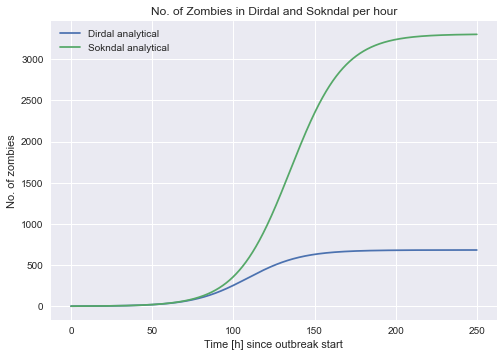

In [11]:
# Analytical solution for Z(t)
def Z(t,S0,Z0,Beta):
    return (S0+Z0)/(1+(S0/Z0)*np.exp(-Beta*t))

#Constants
Z0 = 1 # No of initial zonbies (both Dirdal and Sokndal)
ND = 683 # No of inhabitants Dirdal
NS = 3305 # No. of inhabitants Sokndal
S0D = ND - Z0 # No. of initial susceptible Dirdal
S0S = NS - Z0 # No. of initial susceptible Sokndal
Beta = 0.06 # Beta0
max_t = 250 # Max time for plotting
dt = 0.1 # time step for plotting
t = np.arange(0,max_t,dt)

# Solve functions
ZD = Z(t,S0D,Z0,Beta)
ZS = Z(t,S0S,Z0,Beta)

# Plot no. of zombies per hour in Dirdal and Sokndal
plt.plot(t,ZD, label="Dirdal analytical")
plt.plot(t,ZS, label="Sokndal analytical")
plt.xlabel("Time [h] since outbreak start")
plt.ylabel("No. of zombies")
plt.legend()
plt.title("No. of Zombies in Dirdal and Sokndal per hour")

The figure shows the evolution of the zombie invasion in Dirdal and Sokndal. The figure shows that eventually, all inhabitants will turn into zombies. This confirms the calculations done in part 2 above, that the entire population will turn into zombies.

#### Part 4:

We now wish to use our ODE solvers to compute numerical solutions to the zombie outbreak in Dirdal and Sokndal.


In [12]:
# SZ-model function
def f_sz(y,t, Beta, N):
    dS = -(Beta/N)*y[0]*y[1]
    dZ = (Beta/N)*y[0]*y[1]
    return np.array([dS,dZ])

Text(0.5, 1.0, 'No. of Zombies in Dirdal and Sokndal per hour \nAnalytical vs numerical solution')

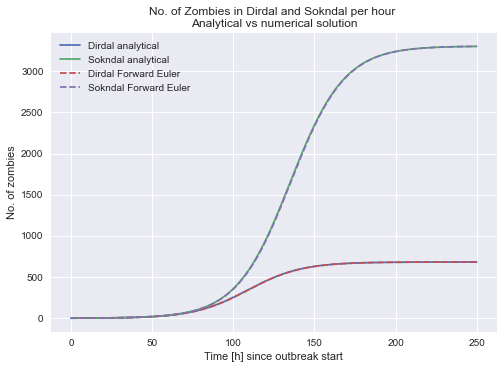

In [13]:
# Comparison of Forward Euler and analytical solution:
y0D = np.array([S0D,Z0]) # Initial state Dirdal
y0S = np.array([S0S,Z0]) # Initial state Sokndal
    
# Solve using Forward Euler    
FEu_dirdal = ForwardEuler(f_sz,y0D,dt) # initiate model
t_dir, y_dir = FEu_dirdal.solve(max_t, Beta=Beta, N=ND) #solve and get time, S and Z
FEu_sokndal = ForwardEuler(f_sz,y0S,dt)
t_sok, y_sok = FEu_sokndal.solve(max_t, Beta=Beta, N=NS)

#Plotting:
plt.plot(t,ZD, label="Dirdal analytical")
plt.plot(t,ZS, label="Sokndal analytical")
plt.plot(t_dir, y_dir[:,1], '--',label="Dirdal Forward Euler") # plot zombies (2nd column)
plt.plot(t_sok, y_sok[:,1], '--',label="Sokndal Forward Euler")
plt.xlabel("Time [h] since outbreak start")
plt.ylabel("No. of zombies")
plt.legend()
plt.title("No. of Zombies in Dirdal and Sokndal per hour \nAnalytical vs numerical solution")


The figure shows the anaytical zombie outbreak in Dirdal and Sokndal, as well as the Forward Euler numerical solution, implemented with step-size 0.1. The Forward Euler matches the analytical solution well when implemented with this time step. 

Text(0.5, 1.0, 'No. of Zombies in Dirdal and Sokndal per hour \nAnalytical vs numerical solution')

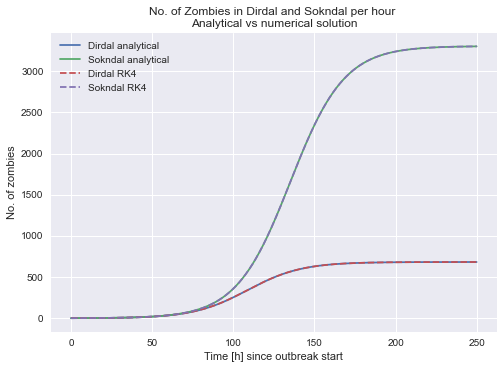

In [15]:
# Comparison of Runge Kutta 4th Order and analytical solution:

RK_dirdal = RungeKutta(f_sz,y0D,dt)
t_rkdir, y_rkdir = RK_dirdal.solve(max_t, Beta=Beta, N=ND)
RK_sokndal = RungeKutta(f_sz,y0S,dt)
t_rksok, y_rksok = RK_sokndal.solve(max_t, Beta=Beta, N=NS)

#Plotting:
plt.plot(t,ZD, label="Dirdal analytical")
plt.plot(t,ZS, label="Sokndal analytical")
plt.plot(t_rkdir, y_rkdir[:,1], '--',label="Dirdal RK4")
plt.plot(t_rksok, y_rksok[:,1], '--',label="Sokndal RK4")
plt.xlabel("Time [h] since outbreak start")
plt.ylabel("No. of zombies")
plt.legend()
plt.title("No. of Zombies in Dirdal and Sokndal per hour \nAnalytical vs numerical solution")

We see that the 4th order Runge-Kutta also matches the analytical solution using a step-size of 0.1.

A time step of 1 will be tested for Dirdal to see whether the numerical solvers can give accurate results with a larger time step.

Text(0.5, 1.0, 'No. of Zombies in Dirdal and Sokndal per hour \nTime step, dt = 1')

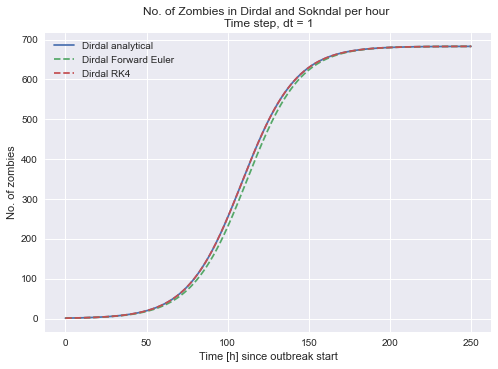

In [16]:
#set time step:
dt = 1

#solve ODEs
t_dir, y_dir = ForwardEuler(f_sz,y0D,dt).solve(max_t, Beta=Beta, N=ND)
t_rkdir, y_rkdir = RungeKutta(f_sz,y0D,dt).solve(max_t, Beta=Beta, N=ND)


#Plotting:
plt.plot(t,ZD, label="Dirdal analytical")
plt.plot(t_dir, y_dir[:,1], "--", label="Dirdal Forward Euler")
plt.plot(t_rkdir, y_rkdir[:,1], "--", label="Dirdal RK4")
plt.xlabel("Time [h] since outbreak start")
plt.ylabel("No. of zombies")
plt.legend()
plt.title(f"No. of Zombies in Dirdal and Sokndal per hour \nTime step, dt = {dt}")

We can see that the Runge_Kutta method still follows the analytical solution accurately, however, the Euler method is starting to get errors in the result. 

We see that we can use a larger time step of 1 for the Runge-Kutta method, but have to use a smaller time step for the Forward Euler method. 

#### Part 5:

The zombie infection rate as a function of time can be modelled as:

\begin{equation}
   \beta(t) = \beta_0 e^{-\lambda t}.
\end{equation}

And after a specific time $T$, the probability of infection will be reduced to 60% of its initial value. $\lambda$ in the expression for $\beta$ above can be estimated from the equation below:
\begin{equation}
   e^{-\lambda T} = 0.6
\end{equation}

Giving the following expression for $\lambda$:
\begin{equation}
   \lambda = -\frac{1}{T} \ln0.6
\end{equation}

In Sokndal, it takes 48 hours for the probability of being infected by a zombie to drop by 40% and this number is 72 hours for Dirdal. $\lambda$ for both places is given below:

\begin{equation}
   \lambda_{Dirdal} = -\frac{1}{72} \ln0.6 \simeq 0.007095
\end{equation}

\begin{equation}
   \lambda_{Sokndal} = -\frac{1}{48} \ln0.6 \simeq 0.01064
\end{equation}

Text(0.5, 1.0, 'No. of Zombies in Dirdal and Sokndal per hour \nNumerical solution with zombie-infection rate \nas a function of time')

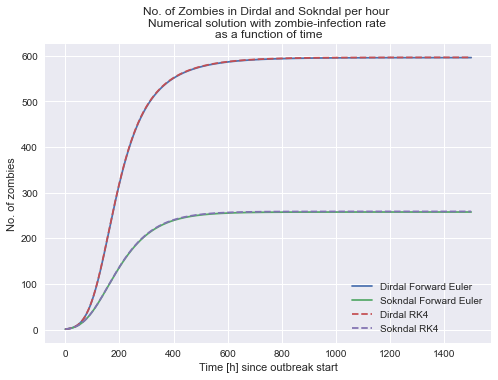

In [17]:
# Beta function:
def beta(t,beta0,lam):
    return beta0*np.exp(-lam*t)

# Update function for SZ-model to be able to get Beta as a function:
def f_sz(y,t, beta, N, **kwargs):
    if not isinstance(beta, (int,float)): #If beta is not a number, then calculate beta based on function.
        beta0 = kwargs.get('beta0')
        lam = kwargs.get('lam')
        beta = beta(t,beta0,lam)    


    return (beta/N)*y[0]*y[1]*np.array([-1,1])

# Set max time and time step
max_t = 1500
dt = 0.1

#Constants
lamD = -(1/72)*np.log(0.6)
lamS = -(1/48)*np.log(0.6)
Beta0 = 0.06 # Using the same value as previously as Beta0

#Solve ODEs with Beta function
t_dir, y_dir = ForwardEuler(f_sz,y0D,dt).solve(max_t, beta = beta, beta0 = Beta0, lam = lamD, N=ND)
t_sok, y_sok = ForwardEuler(f_sz,y0S,dt).solve(max_t, beta = beta, beta0 = Beta0, lam = lamS, N=NS)
t_rkdir, y_rkdir = RungeKutta(f_sz,y0D,dt).solve(max_t, beta = beta, beta0 = Beta0, lam = lamD, N=ND)
t_rksok, y_rksok = RungeKutta(f_sz,y0S,dt).solve(max_t, beta = beta, beta0 = Beta0, lam = lamS, N=NS)

# Plot solutions:
plt.plot(t_dir, y_dir[:,1], label="Dirdal Forward Euler") # plot zombies (2nd column)
plt.plot(t_sok, y_sok[:,1], label="Sokndal Forward Euler")
plt.plot(t_rkdir, y_rkdir[:,1], '--',label="Dirdal RK4")
plt.plot(t_rksok, y_rksok[:,1], '--',label="Sokndal RK4")
plt.xlabel("Time [h] since outbreak start")
plt.ylabel("No. of zombies")
plt.legend()
plt.title("No. of Zombies in Dirdal and Sokndal per hour \nNumerical solution with zombie-infection rate \nas a function of time")

In the figure we see that the number of zombies converges. This value can be identified by extracting the last value from the output, as shown below: 

In [18]:
print(f"In Dirdal there will be roughly {y_rkdir[-1,0]: .0f} survivors")
print(f"In Sokndal there will be roughly {y_rksok[-1,0]: .0f} survivors")

In Dirdal there will be roughly  86 survivors
In Sokndal there will be roughly  3046 survivors


As Sokndal's zombie infection rate drops to 60% 24 hours earlier than in Dirdal, a greater proportion of the population will survive the zombie attack. 

### Exercise 3: Counter-strike

The SZ-model with time-dependent $\beta$ studied so far allows for some humans to survive. This happens because the probability of infection eventually drops to zero. However, from data \[3] on real outbreaks we know that humans eventually will start to fight back and kill zombies. The SZ-model further assumes that a bitten human turn into a zombie instantaneosly. Sources \[4] indicate that this in not the case. In fact, there is a latency period of about $\frac{1}{\sigma} = 24$ hours. We now refine out model by adding two new compartements: 

E: exposed humans, people that have been bitten or scratched by a zombie, but who still remain-non contagious to other.

R: removed (killed) zombies.

We hereby refer to the refined model as the SEZR-model, described by the compartement equations: 

$$
\begin{align}
\frac{\mathrm{d}S(t)}{\mathrm{d}t} &= -\beta(t)\cdot\frac{S(t)Z(t)}{N} \,, \\ 
\frac{\mathrm{d}E(t)}{\mathrm{d}t} &= \beta(t)\cdot\frac{S(t)Z(t)}{N}-\sigma\cdot{E(t)} \,, \\ 
\frac{\mathrm{d}Z(t)}{\mathrm{d}t} &= \sigma\cdot{E(t)}-\left(\alpha+\omega(t)\right)\frac{S(t)Z(t)}{N} \,, \\ 
\frac{\mathrm{d}R(t)}{\mathrm{d}t} &= \left(\alpha+\omega(t)\right)\frac{S(t)Z(t)}{N} \,.
\end{align}
$$

In the above equations, the parameter $\alpha$ can be thought of as the average rate of zombie killing, while the function $\omega(t)$ represents a series of violent attacks launched by humans at specific points in time. Following \[5], we define:
$$
\begin{equation}
\omega(t) = a\displaystyle\sum_{i=1}^m
\exp\left(-\frac{1}{2}(\frac{t-T_i}{T_\sigma})^2\right)\,,
\end{equation}
$$

where $a$ and $T_\sigma$ are constant parameters, and where $T_1, T_2, \ldots, T_m$ are the times at which the humans launch violent attacks.

#### Part 1:

We wish to implement the violent attack function $\omega(t)$ as a Python function.

In [19]:
#Violent attack function
def f_omega(t,a,Tsig,T):
    return a*sum(np.exp(-0.5*((t-T[i])**2/(Tsig**2))) for i in range(len(T)))

Text(0.5, 1.0, 'Violent attacks as a function of time')

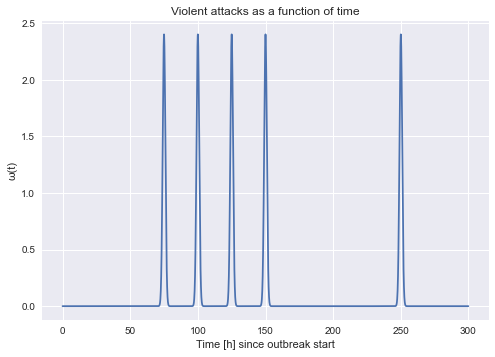

In [20]:
#Plot the function for a = 40*beta0 and T_sigma  = 1. 
beta0 = 0.06 
a = 40*beta0 
T_sigma = 1
T_i = [75,100,125,150,250]
times = np.arange(0,300,0.1)
plt.plot(times,f_omega(t=times,a=a,Tsig=T_sigma,T=T_i))
plt.xlabel("Time [h] since outbreak start")
plt.ylabel("\u03C9(t)")
plt.title("Violent attacks as a function of time")

The figure displays violent attacks as a function of time. 

The physical meaning of $T_{\sigma}$ is length of attacks. $a$ is probability to kill in an attack per unit time interval. 

#### Part 2:

For simplicity we suppose that $\beta(t)=\beta_0$ is constant. We now run a few simulations for Dirdal. Only the Runge-Kutta method is used as it has a higher order of accuracy, as stated earlier in Exercise 2, part 4. 


In [21]:
#Beta = B_0
beta0 = 0.06

#Dirdal:
N1 = 683
Z_0 = 1
S_0 = N1 - Z_0
E_0 = 0 #Initial exposed value is 0
R_0 = 0 #Initial removed 
y0 = [S_0,E_0,Z_0,R_0]
dt=0.1


def f_sezr(y,t, beta, N, sigma, alpha, omega, **kwargs):
    """
    The SEZR compartement model. 
    Parameters: 
    y: current step solution.
    t: current time. 
    beta: zombie-infection rate. Can either be a function or a constant.
    N: population size.
    sigma: 1/latency.
    alpha: average rate of zombie killing.
    omega: violent attacks. 
    """
    if not isinstance(beta, (int,float)): #If beta is not a number, then calculate beta based on function.
        beta0 = kwargs.get('beta0')
        lam = kwargs.get('lam')
        beta = beta(t,beta0,lam)
    if not isinstance(omega, (int,float)): #If omega is not a number, then calculate omega using omega function. 
        a = kwargs.get('a')
        Tsig = kwargs.get('Tsig')
        T = kwargs.get('T')
        omega = omega(t,a,Tsig,T)
    
    ds = -(beta/N)*y[0]*y[2]
    de = (beta/N)*y[0]*y[2]-sigma*y[1]
    dz = sigma*y[1]-(alpha+omega)*(y[0]*y[2])/N
    dr = (alpha+omega)*(y[0]*y[2])/N
    return np.array([ds,de,dz,dr]) 



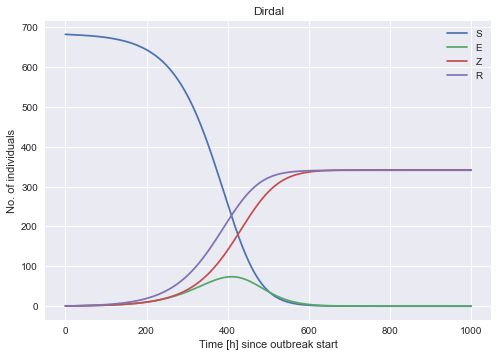

In [22]:
#Constants as defined in the exercise. 
alpha = 0.03
omega = 0
sigma = 1/24
max_t = 1000

t, y = RungeKutta(f = f_sezr,y0=y0,dt=dt).solve(max_t,omega=omega,alpha=alpha,N=N1,beta=beta0,sigma=sigma) 

plt.plot(t,y[:,0],label="S")
plt.plot(t,y[:,1],label="E")
plt.plot(t,y[:,2],label="Z")
plt.plot(t,y[:,3],label="R")
plt.xlabel("Time [h] since outbreak start")
plt.title("Dirdal")
plt.ylabel("No. of individuals")
plt.legend()

We see that eventually, everyone dies or turn into a zombie.

Further, we wish to study if it is possible to survive. We do this by varying $\alpha$.

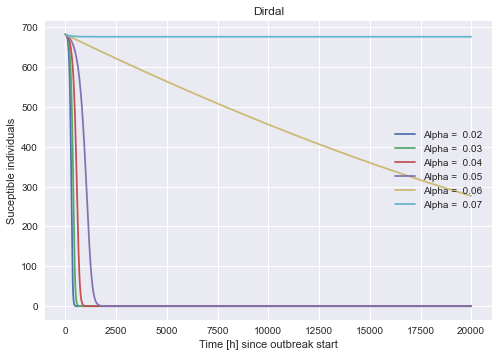

In [23]:
alpha = np.arange(0.02,0.08,0.01)
max_t = 20000
dt= 1 

for i in alpha:
    t, y = RungeKutta(f = f_sezr,y0=y0,dt=dt).solve(max_t,omega=omega,alpha=i,N=N1,beta=beta0,sigma=sigma) 
    plt.plot(t,y[:,0],label=f"Alpha = {i: .2f}")


plt.xlabel("Time [h] since outbreak start")
plt.title("Dirdal")
plt.ylabel("Suceptible individuals")
plt.legend(loc=7)

From the figure above, we see that if $\alpha <  \beta$, it is not possible to survive the zombie attack. If $\alpha = \beta$, then it is possible to survive far longer compared to when $\alpha <  \beta$. For values $\alpha >  \beta$, we see from the figure that it is possible to survive.

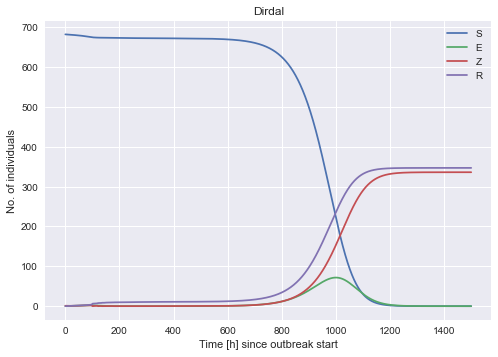

In [24]:
max_t = 1500
dt = 0.1
alpha= 0.03
sigma = 1/24
beta0 = 0.06
a = 40*beta0 
T_sigma = 1
T_i = [100, 120, 135, 150, 180, 210, 250, 300, 350, 400]

t, y = RungeKutta(f = f_sezr,y0=y0,dt=dt).solve(max_t,omega=f_omega,alpha=alpha,N=N1,beta=beta0,sigma=sigma, a = a, Tsig = T_sigma, T = T_i) 

plt.plot(t,y[:,0],label="S")
plt.plot(t,y[:,1],label="E")
plt.plot(t,y[:,2],label="Z")
plt.plot(t,y[:,3],label="R")
plt.xlabel("Time [h] since outbreak start")
plt.title("Dirdal")
plt.ylabel("No. of individuals")
plt.legend()



Only turning on violent attacks may increase the time until the zombies wil, but it still does not seem to be enough to survive the zombie apocalypse if $\alpha < \beta$. We see that a fraction of a zombie can still infect a human in this model and if the attacks stop, the zombies will win in the end. 

We now modify the function so that if the number of zombies drop below one, we set $\beta \to 0$. Similarly, if $E(t) < 1$, we set $\sigma \to 0$. Then we see that the humans can survive the zombie apocalypse even when $\alpha < \beta$.


In [25]:
#Function with modifications commented. 
def f_sezr_mod(y,t, beta, N, sigma, alpha, omega, **kwargs):
    """
    The SEZR compartement model. 
    Parameters: 
    y: current step solution.
    t: current time. 
    beta: zombie-infection rate. Can either be a function or a constant.
    N: population size.
    sigma: 1/latency.
    alpha: average rate of zombie killing.
    omega: violent attacks. 
    """
    if not isinstance(beta, (int,float)): #If beta is not a number, then calculate beta based on function.
        beta0 = kwargs.get('beta0')
        lam = kwargs.get('lam')
        beta = beta(t,beta0,lam)
    if not isinstance(omega, (int,float)): #If omega is not a number, then calculate omega using omega function. 
        a = kwargs.get('a')
        Tsig = kwargs.get('Tsig')
        T = kwargs.get('T')
        omega = omega(t,a,Tsig,T)
    
    if y[2] < 1:  #Modification: If Z < 1, set beta = 0
        beta = 0
    if y[1] < 1: #Modification: If E(t) < 1, set sigma = 0. 
        sigma = 0
    ds = -(beta/N)*y[0]*y[2]
    de = (beta/N)*y[0]*y[2]-sigma*y[1]
    dz = sigma*y[1]-(alpha+omega)*(y[0]*y[2])/N
    dr = (alpha+omega)*(y[0]*y[2])/N
    return np.array([ds,de,dz,dr]) 


In [26]:
max_t = 500
dt = 0.1
t, y = RungeKutta(f = f_sezr_mod,y0=y0,dt=dt).solve(max_t,omega=f_omega,alpha=alpha,N=N1,beta=beta0,sigma=sigma, a = a, Tsig = T_sigma, T = T_i) 


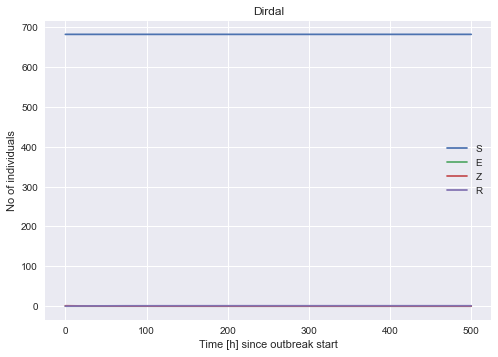

In [27]:
plt.plot(t,y[:,0],label="S")
plt.plot(t,y[:,1],label="E")
plt.plot(t,y[:,2],label="Z")
plt.plot(t,y[:,3],label="R")
plt.xlabel("Time [h] since outbreak start")
plt.title("Dirdal")
plt.ylabel("No of individuals")
plt.legend()

Using the modifications as described above, we see that it is possible to survive the zombies, as shown in the above figure. 

### Exercise 4: Compartment model for Covid-19

In this final part of the project, we wish to study the transmission of the corona virus disease, Covid-19. This can be modeled using a compartment model with five compartments: 

$$
\begin{align}
\frac{\mathrm{d}S(t)}{\mathrm{d}t} &= -\beta(t)\cdot\frac{S(t)I(t)}{N} \,, \\ 
\frac{\mathrm{d}E(t)}{\mathrm{d}t} &= \beta(t)\cdot\frac{S(t)I(t)}{N}-\sigma\cdot{E(t)} \,, \\ 
\frac{\mathrm{d}I(t)}{\mathrm{d}t} &= \sigma\cdot{E(t)}-\gamma\cdot I(t) \,, \\ 
\frac{\mathrm{d}R(t)}{\mathrm{d}t} &= (1-f)\cdot\gamma\cdot I(t) \,, \\ 
\frac{\mathrm{d}D(t)}{\mathrm{d}t} &= f\cdot\gamma\cdot I(t)\,.
\end{align}
$$

Note that we have changed the notation for the infectious compartment from
$Z(t)$ to $I(t)$. The exposed compartment is the same as before, but
we have split people who no longer have the disease into two categories:

$R(t)$ is the number of people who have become immune ("Recovered").

$D(t)$ denotes the number of dead individuals.




#### Part 1:

We have been provided coronavirus data for several countries. We start off by extracting some information from this data.

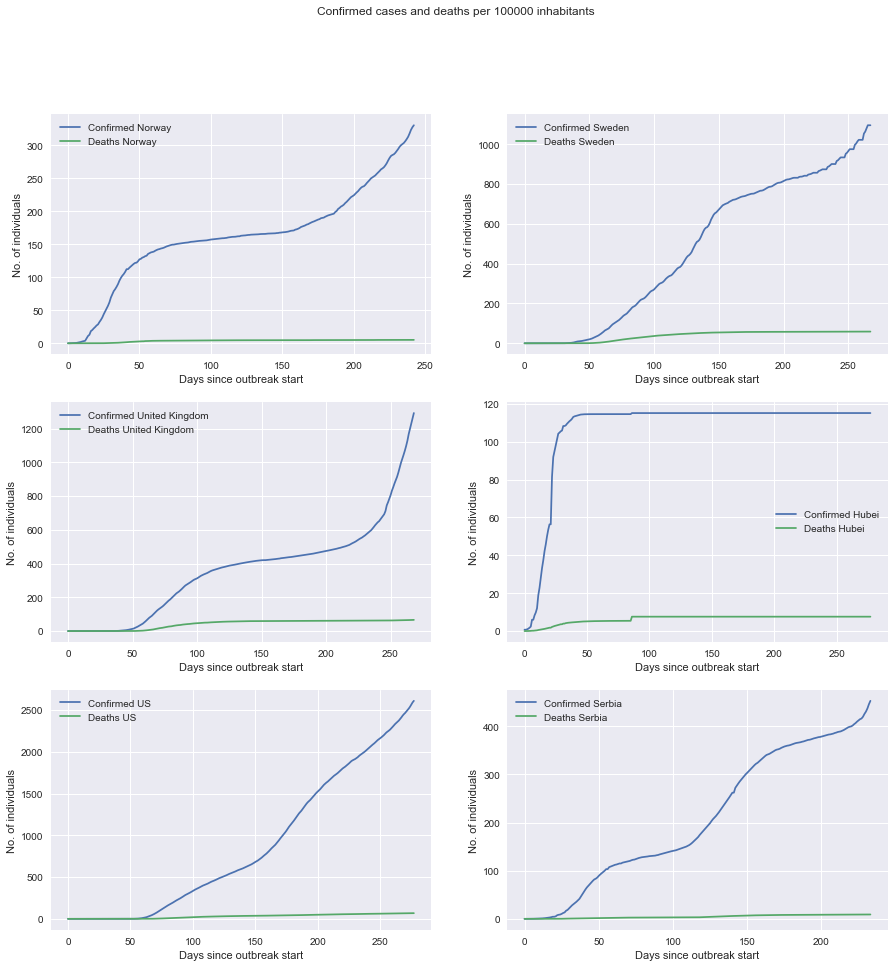

In [28]:

def read_file(filename, country=None):
    cordat = pd.read_table(filename)
    if country != None:
        return cordat[cordat['LOCATION'] == country]
    else:
        return cordat


def plot_corona_data(country_data, population=1, normalize=False):
    #country_data = country_data.reset_index()
    if normalize == True:
        confirmed = country_data['CONFIRMED']*100000/population
        deaths = country_data['DEATHS']*100000/population
        #plt.title("Confirmed cases and deaths per 100000 inhabitants")
        #plt.ylabel("")
    else:
        confirmed = country_data['CONFIRMED']
        deaths = country_data['DEATHS']
        #plt.title("Confirmed cases and deaths")
    labelc =str(f"Confirmed {country_data['LOCATION'].iloc[1]}")
    labeld =str(f"Deaths {country_data['LOCATION'].iloc[1]}")
    plt.plot(country_data['ELAPSED_TIME_SINCE_OUTBREAK'], confirmed, label=labelc)
    plt.plot(country_data['ELAPSED_TIME_SINCE_OUTBREAK'], deaths, label=labeld)
    plt.legend()

pop_Nor = 5421241 
pop_Swe = 10099265
pop_UK = 67886011
pop_Hub = 59170000
pop_US = 331002651
pop_Srb = 8724190

Norway = read_file('corona_data.dat', 'Norway')
Sweden = read_file('corona_data.dat', 'Sweden')
UK = read_file('corona_data.dat', 'United Kingdom')
Hubei = read_file('corona_data.dat', 'Hubei')
US = read_file('corona_data.dat','US')
Serbia = read_file('corona_data.dat','Serbia')

plt.figure(figsize=(15,15))
plt.suptitle("Confirmed cases and deaths per 100000 inhabitants")
plt.subplot(321)
plt.xlabel("Days since outbreak start")
plt.ylabel("No. of individuals")
plot_corona_data(Norway, pop_Nor, normalize=True)
plt.subplot(322)
plt.xlabel("Days since outbreak start")
plt.ylabel("No. of individuals")
plot_corona_data(Sweden, pop_Swe, normalize=True)
plt.subplot(323)
plt.xlabel("Days since outbreak start")
plt.ylabel("No. of individuals")
plot_corona_data(UK, pop_UK, normalize=True)
plt.subplot(324)
plot_corona_data(Hubei, pop_Hub, normalize=True)
plt.ylabel("No. of individuals")
plt.xlabel("Days since outbreak start")
plt.subplot(325)
plt.xlabel("Days since outbreak start")
plt.ylabel("No. of individuals")
plot_corona_data(US, pop_US, normalize=True)
plt.subplot(326)
plt.xlabel("Days since outbreak start")
plt.ylabel("No. of individuals")
plot_corona_data(Serbia, pop_Srb, normalize=True)


The figure shows the reported coronavirus cases and deaths, normalized in seperate subplots for Norway, Sweden, UK, Hubei ( China), US and Serbia. Population data is taken from ref. \[13\].

#### Part 2: 

Next, we want to fit our model to the data. To this end, we use the scipy.optimize.curve_fit function \[6]. We now calculate $\beta (t)$ as in Exercise 2, part 5. We assume that the mean infectious perioud is approximately 20 days \[7], $\frac{1}{\gamma} = 20$, and we also assume the mean incubation period to be 5.1 days, $\frac{1}{\sigma} = 5.1$. Thus, the only unknows are $\beta_0, \lambda$ and the death rate $f$.

Text(0.5, 1.0, 'Covid-19 status in Hubei')

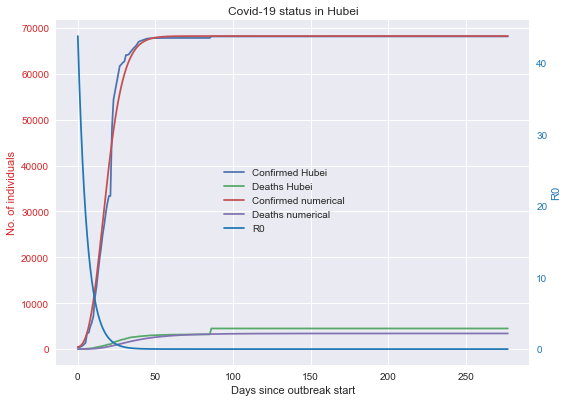

In [36]:

def f_seird(y,t, beta, N, sigma, gamma, f, **kwargs):
    """
    The SEIRD-compartement model. 
    Parameters: 
    y: current step solution.
    t: current time. 
    beta: infection rate. Can either be a function or a constant.
    N: population size.
    sigma: 1/latency period.
    gamma: 1/incubation period. 
    f: death rate. 
    Output: current step solutions for s(sucseptible),e(exposed),i(infected),r(recovered),d(dead)
    """
    if not isinstance(beta, (int,float)):
        beta0 = kwargs.get('beta0')
        lam = kwargs.get('lam')
        beta = beta(t,beta0,lam)

    ds = -(beta/N)*y[0]*y[2]
    de = (beta/N)*y[0]*y[2]-sigma*y[1]
    di = sigma*y[1]-gamma*y[2]
    dr = (1-f)*gamma*y[2]
    dd = f*gamma*y[2]
    return np.array([ds,de,di,dr,dd]) 

def func(t, beta0, lam):
    """
    Parameters:
    t: current time. 
    beta0: infection rate.
    lam: rate.
    """
    t, y = SEIRD(t, beta0, lam)
    return y[:,2] + y[:,3] + y[:,4]
    

def SEIRD(t, beta0, lam):
    """
    Parameters:
    t: current time. 
    beta0: infection rate.
    lam: rate.
    """
    max_t = max(t)
    gamma = 1/20
    sigma = 1/5.1
    N_hub = 59170000
    f = 0.05
    dt = 1
    I0 = 444 #From datafile, initial confirmed cases for Hubei is 444. 
    E0 = 0
    R0 = 28 #From datafile
    D0 = 17 #From datafile
    S0 = N_hub - I0
    y0 = [S0, E0,I0,R0, D0]
    RK = RungeKutta(f_seird,y0,dt)
    return RK.solve(max_t, beta=beta, N=N_hub,sigma=sigma, 
                    gamma = gamma, f = f, beta0 = beta0, lam = lam)

Hubei = read_file('corona_data.dat', 'Hubei')
xdata = Hubei['ELAPSED_TIME_SINCE_OUTBREAK']
ydata = Hubei['CONFIRMED']
popt, pcov = curve_fit(func, xdata, ydata, p0=[1, 0.1])
t, y = SEIRD(xdata, *popt)

gamma = 1/20
R0 = beta(t, *popt) / gamma 
    
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Days since outbreak start')
ax1.set_ylabel('No. of individuals', color=color)
plot_corona_data(Hubei)
ax1.plot(xdata, func(xdata, *popt), label="Confirmed numerical")
plt.plot(t, y[:,4], label="Deaths numerical")
ax1.tick_params(axis='y', labelcolor=color)
ax1.get_legend().remove()
    
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
color = 'tab:blue'
ax2.set_ylabel('R0', color=color)  # we already handled the x-label with ax1
ax2.plot(t, R0, color=color, label="R0")
ax2.tick_params(axis='y', labelcolor=color)

    
fig.legend(loc=10)
ax2.grid(False)   
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Covid-19 status in Hubei")


In the figure, we have plotted the data for Hubei confirmed cases and death linked to the corona virus. We also plot the Runge Kutta numerical solution, using the identified parameters for $\beta_0$ and $\lambda$. The parameters where identified using the scipy.optimize.curve_fit function as in the code above. Note the secondary right-hand vertical axsis, $R_0$, which is the basic reproduction number versus time. This is found by $\mathcal{R}_0 = \frac{\beta(t)}{\gamma}$. 

#### Part 3:

We will now try to use the parameters found for Hubei in Part 2 to use the numerical model to predict the spread of the virus in the countries considered above. Then this is compared to the actual data to see whether the spread in Hubei, China can be used to model the spread in the rest of the world. 

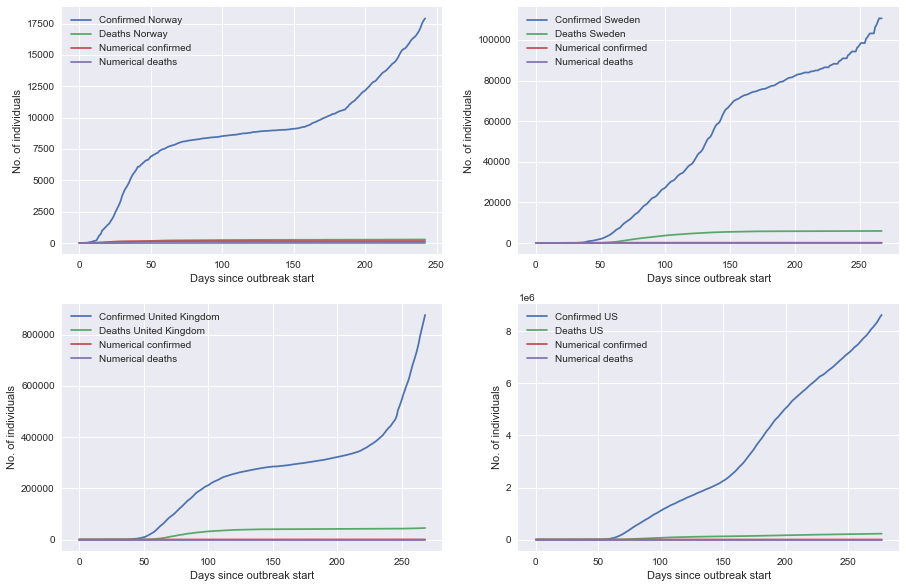

In [37]:
    
gamma = 1/20
sigma = 1/5.1
N_Nor = pop_Nor
f = 0.05
dt = 1
I0 = 1
E0 = 0
R0 = 0
D0 = 0
S0 = N_Nor - I0
y0 = [S0, E0,I0,R0, D0]
RK = RungeKutta(f_seird,y0,dt)
t_nor, y_nor = RK.solve(max_t = max(Norway['ELAPSED_TIME_SINCE_OUTBREAK']), beta=beta, N=N_Nor,sigma=sigma, gamma = gamma, f = f, beta0 = popt[0], lam = popt[1])
y_confirmed_nor = y_nor[:,2] + y_nor[:,3] + y_nor[:,4]


N_Swe = pop_Swe
S0 = N_Swe - I0
y0 = [S0, E0, I0, R0, D0]
RK = RungeKutta(f_seird,y0,dt)
t_swe, y_swe = RK.solve(max_t = max(Sweden['ELAPSED_TIME_SINCE_OUTBREAK']), beta=beta, N=N_Swe,sigma=sigma, gamma = gamma, f = f, beta0 = popt[0], lam = popt[1])
y_confirmed_swe = y_swe[:,2] + y_swe[:,3] + y_swe[:,4]

N_US = pop_US
S0 = N_US - I0
y0 = [S0, E0, I0, R0, D0]
RK = RungeKutta(f_seird,y0,dt)
t_us, y_us = RK.solve(max_t = max(US['ELAPSED_TIME_SINCE_OUTBREAK']), beta=beta, N=N_US,sigma=sigma, gamma = gamma, f = f, beta0 = popt[0], lam = popt[1])
y_confirmed_us = y_us[:,2] + y_us[:,3] + y_us[:,4]

N_UK = pop_UK
I0 = 2 #UK initial nifected is 2, as found in datafile
S0 = N_UK - I0
y0 = [S0, E0, I0, R0, D0]
RK = RungeKutta(f_seird,y0,dt)
t_uk, y_uk = RK.solve(max_t = max(UK['ELAPSED_TIME_SINCE_OUTBREAK']), beta=beta, N=N_UK,sigma=sigma, gamma = gamma, f = f, beta0 = popt[0], lam = popt[1])
y_confirmed_uk = y_uk[:,2] + y_uk[:,3] + y_uk[:,4]

plt.figure(figsize=(15,10))
plt.subplot(221)
plot_corona_data(Norway)
plt.plot(t_nor, y_confirmed_nor, label= "Numerical confirmed")
plt.plot(t_nor, y_nor[:,4], label= "Numerical deaths")
plt.xlabel("Days since outbreak start")
plt.ylabel("No. of individuals")
plt.legend()
plt.subplot(222)
plot_corona_data(Sweden)
plt.plot(t_swe, y_confirmed_swe, label= "Numerical confirmed")
plt.plot(t_swe, y_swe[:,4], label= "Numerical deaths")
plt.xlabel("Days since outbreak start")
plt.ylabel("No. of individuals")
plt.legend()
plt.subplot(223)
plot_corona_data(UK)
plt.plot(t_uk,y_confirmed_uk, label="Numerical confirmed")
plt.plot(t_uk, y_uk[:,4], label= "Numerical deaths")
plt.xlabel("Days since outbreak start")
plt.ylabel("No. of individuals")
plt.legend()
plt.subplot(224)
plot_corona_data(US)
plt.plot(t_us,y_confirmed_us, label="Numerical confirmed")
plt.plot(t_us, y_us[:,4], label= "Numerical deaths")
plt.xlabel("Days since outbreak start")
plt.ylabel("No. of individuals")
plt.legend()


We see that by applying the identified $\beta_0$ and $\lambda$ values to other regions, the numerical model do not approximate closely to the measured data in any region. This reflects the fact that Hubei is a region with greater population density than e.g. Norway and Sweden. Thus, we now focus on applying data from the specific regions to identify $\beta_0$ and $\lambda$ for each region.

#### Part 4:

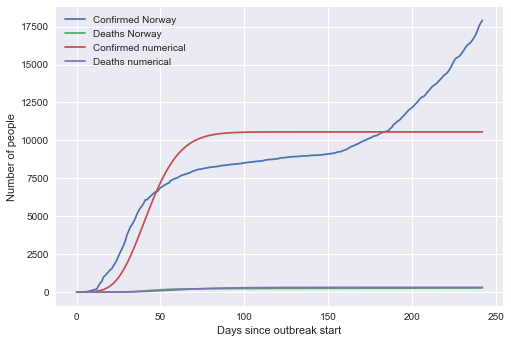

In [38]:
def func_N(t, beta0, lam): #Norway
        t, y = SEIRD_N(t, beta0, lam)
        return y[:,2] + y[:,3] + y[:,4]
    

def SEIRD_N(t, beta0, lam): #Norway
    max_t = max(t) 
    gamma = 1/20
    sigma = 1/5.1
    N_Nor = 5421241 
    f = 0.03
    dt = 1
    I0 = 1
    E0 = 0
    R0 = 0
    D0 = 0
    S0 = N_Nor - I0
    y0 = [S0, E0, I0, R0, D0]
    RK = RungeKutta(f_seird,y0,dt)
    return RK.solve(max_t, beta=beta, N=N_Nor,sigma=sigma, 
                    gamma = gamma, f = f, beta0 = beta0, lam = lam)


xdata_nor = Norway['ELAPSED_TIME_SINCE_OUTBREAK']
ydata_nor = Norway['CONFIRMED']
popt, pcov = curve_fit(func_N, xdata_nor, ydata_nor, p0=[1, 0.1])
t, y = SEIRD_N(xdata_nor, *popt)

    
fig, ax1 = plt.subplots()


plot_corona_data(Norway)
plt.plot(xdata_nor, func_N(xdata_nor, *popt), label="Confirmed numerical")
plt.plot(t, y[:,4], label="Deaths numerical")
plt.ylabel("Number of people")
plt.xlabel("Days since outbreak start")
plt.legend()




We see that the model somewhat follows the data. After approximately the first 50 days, the model over-evaluates the number of confirmed cases. Further, we see that the number of cases starts to increase rapidlt after approximately 175 days, while the model does not. The over-evaluation of the model at day 50 is a response to this rise. However, the model cannot adapt to the second rise. Therefore, it is better to use the model only for the first 150 days: 

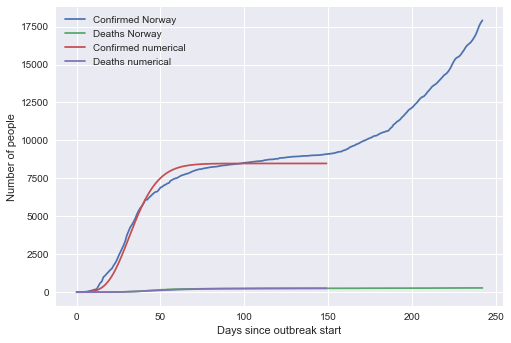

In [40]:
xdata_nor = Norway['ELAPSED_TIME_SINCE_OUTBREAK'][0:150]
ydata_nor = Norway['CONFIRMED'][0:150]
popt, pcov = curve_fit(func_N, xdata_nor, ydata_nor, p0=[1, 0.1])
t, y = SEIRD_N(xdata_nor, *popt)

    
fig, ax1 = plt.subplots()
plot_corona_data(Norway)
plt.plot(xdata_nor, func_N(xdata_nor, *popt), label="Confirmed numerical")
plt.plot(t, y[:,4], label="Deaths numerical")
plt.ylabel("Number of people")
plt.xlabel("Days since outbreak start")
plt.legend()

In the abve figure, we see that the model better matches the first segment of the data when only evaluating for the first 150 days of the pandemic. 

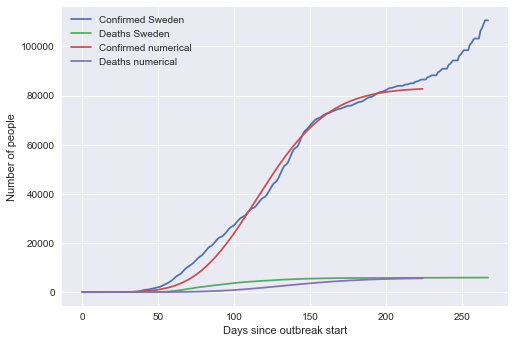

In [41]:
def func_S(t, beta0, lam): #Sweden
        t, y = SEIRD_S(t, beta0, lam)
        return y[:,2] + y[:,3] + y[:,4]
    

def SEIRD_S(t, beta0, lam): #Sweden
    max_t = max(t) 
    gamma = 1/20
    sigma = 1/5.1
    N_Swe = 10099265
    f = 0.07
    dt = 1
    I0 = 1
    E0 = 0
    R0 = 0
    D0 = 0
    S0 = N_Swe - I0
    y0 = [S0, E0, I0, R0, D0]
    RK = RungeKutta(f_seird,y0,dt)
    return RK.solve(max_t, beta=beta, N=N_Swe,sigma=sigma, 
                    gamma = gamma, f = f, beta0 = beta0, lam = lam)



xdata_swe = Sweden['ELAPSED_TIME_SINCE_OUTBREAK'][0:225] 
ydata_swe = Sweden['CONFIRMED'][0:225]
popt, pcov = curve_fit(func_S, xdata_swe, ydata_swe, p0=[1, 0.1])
t, y = SEIRD_S(xdata_swe, *popt)

    


plot_corona_data(Sweden)
plt.plot(xdata_swe, func_S(xdata_swe, *popt), label="Confirmed numerical")
plt.plot(t, y[:,4], label="Deaths numerical")
plt.ylabel("Number of people")
plt.xlabel("Days since outbreak start")
plt.legend()

The Swedish cases and numerical approximation is shown in the figure above. A similar process as the Norwegian data was conducted, and the data was limited to the first 225 days. We see a well represented confirmed cases curve, with some areas under-representing the true data, and other areas over-representing the data. The numerical death curve converges towards the true data, but has a slight under-prediction between days 75 to 160. 

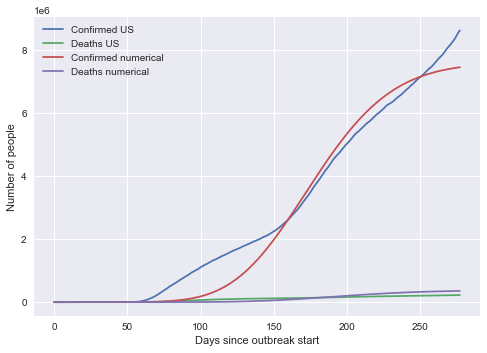

In [42]:
def func_US(t, beta0, lam): #United States
        t, y = SEIRD_US(t, beta0, lam)
        return y[:,2] + y[:,3] + y[:,4]
    

def SEIRD_US(t, beta0, lam): #United States
    max_t = max(t) 
    gamma = 1/20
    sigma = 1/5.1
    N_US = 331002651
    f = 0.05
    dt = 1
    I0 = 1
    E0 = 0
    R0 = 0
    D0 = 0
    S0 = N_US - I0
    y0 = [S0, E0, I0, R0, D0]
    RK = RungeKutta(f_seird,y0,dt)
    return RK.solve(max_t, beta=beta, N=N_US,sigma=sigma, 
                    gamma = gamma, f = f, beta0 = beta0, lam = lam)



xdata_us = US['ELAPSED_TIME_SINCE_OUTBREAK']
ydata_us = US['CONFIRMED']
popt, pcov = curve_fit(func_US, xdata_us, ydata_us, p0=[1, 0.1])
t, y = SEIRD_US(xdata_us, *popt)

    
plot_corona_data(US)
plt.plot(xdata_us, func_US(xdata_us, *popt), label="Confirmed numerical")
plt.plot(t, y[:,4], label="Deaths numerical")
plt.ylabel("Number of people")
plt.xlabel("Days since outbreak start")
plt.legend()

We see that the model struggles to match the data US corona virus data. This is because the data never converges, but simply keeps on increasing. 

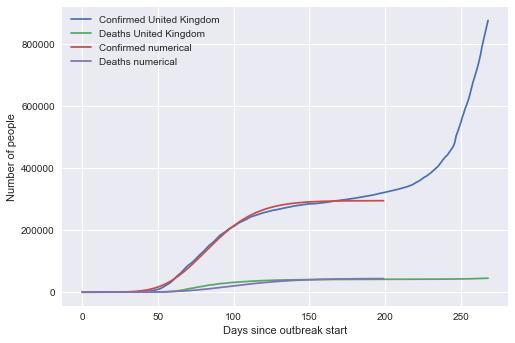

In [43]:
def func_UK(t, beta0, lam): #United Kingdom
        t, y = SEIRD_UK(t, beta0, lam)
        return y[:,2] + y[:,3] + y[:,4]
    

def SEIRD_UK(t, beta0, lam): #United Kingdom
    max_t = max(t) 
    gamma = 1/20
    sigma = 1/5.1
    N_UK = 67886011
    f = 0.15
    dt = 1
    I0 = 1
    E0 = 0
    R0 = 0
    D0 = 0
    S0 = N_UK - I0
    y0 = [S0, E0, I0, R0, D0]
    RK = RungeKutta(f_seird,y0,dt)
    return RK.solve(max_t, beta=beta, N=N_UK,sigma=sigma, 
                    gamma = gamma, f = f, beta0 = beta0, lam = lam)



xdata_uk = UK['ELAPSED_TIME_SINCE_OUTBREAK'][0:200]
ydata_uk = UK['CONFIRMED'][0:200]
popt, pcov = curve_fit(func_UK, xdata_uk, ydata_uk, p0=[1, 0.1])
t, y = SEIRD_UK(xdata_uk, *popt)

    
plot_corona_data(UK)
plt.plot(xdata_uk, func_UK(xdata_uk, *popt), label="Confirmed numerical")
plt.plot(t, y[:,4], label="Deaths numerical")
plt.ylabel("Number of people")
plt.xlabel("Days since outbreak start")
plt.legend()

As with the Norwegian data and the second rise in confirmed cases, the model fitted to the UK data did not manage to follow the second spike, and had to be limited to 200 days. When limited to 200 days, the model matches very well to the confirmed cases. The death rate had to be increased to a 0.15 in order to match the confirmed number of deaths. 

### Conclusion:

In this project, we learned how to implement solvers for systems of first-order ordinary differential equations (ODEs) in Python. We studied the explicit Forward Euler and 4th order Runge-Kutta scheme. The numerical schemes were tested on a given second-order differntial equation. We converted this second-order equation into a system of first order equations, and used our numerical schemes to solve these first-order equations. Compared to the analytical second order equation, we found 4th order Runge-Kutta scheme to provide the most accurate solution. The Forward Euler method accumulated errors as time progressed. By reducing the time-step, these errors where reduced but still present. We compared the runtime of the two numerical schemes. Our findings show that the runtime difference between the two numerical scehmes where a factor of 5 in factor of the Forward Euler method. This proved to be the case for two different time-steps. However, we found that the 4th order Runge-Kutta scheme provided more accurate results at a larger time-step. Therefore we can use this scheme at a higher step-size while still obtaining better approxiamtions to the analytical solution than what the Forward Euler method can do at a similar step-size. 

Further, we learned about the use of compartement models in epidemic disease study. We were introduced to the SZ-model, a compartement model consisting of Susceptible humans (S) and Zombies (Z). The model presented these two compartemends as differential equations. We found the analytical solution to these equations, and could use this to determine that an entire population eventually will turn into zombies in the SZ model. By appliying our numerical schemes to compute solutions and compare with the analytical solution, we manage to identify the Runge-Kutta scheme to result in better accuracy when compared to the Forward Euler scheme.  
The compartement model was increased with two new compartements, E (exposed humans) and R (removed, read: killed, zombies), becoming the SEZR-model. This model accounted for the fact that people can be in other states than simply a susceptible human or zombie, as the SZ-model did. We were introduced to concepts about zombie outbreaks, specifically how people eventually will start to fight back. We implemened an attack function and found that attacking zombies are crucial for survival. However, since the SEZR model is a closed model, it does not account for the fact that people from the neighboring village can come and help the humans in the fight agains the zombies. Similarly, the model does not account for the possibility of a zombie going to the neighboring village and turning everyone into a zombie, and then returning with a mob of zombies to attack the remaining humans. 

The model was further expanded into a 5 compartement model, the SEIRD-model, for the study of Covid-19. The additional compartment added was D for dead individuals and R became the number of recovered individuals. By analyzing real-world data and using a parameter-identifying optimization routine, scipy.optimize.curve_fit, we managed to identify parameters to use in modelling the Covid-19 pandemic using our 4th order Runge-Kutta Scheme. We managed to recreate several Covid-19 graphs for confirmed cases and death for several countries such as Norway, Sweden, United Kindom and United States. A weakness with our model was that it was not able recreate a second wave of rise in confimed cases after an initial flattening of the confirmed cases curve. In some cases (e.g. Norway), we therefore had to limit the data that was used in the optimization function. This resulted in a better approxiamtion in the data segment that was in fact used. 

In the SEIRD-model, we implemented the $\beta(t)$ function from the SEZR-model. In the SEZR-model, $\beta(t)$ is assumed to be time-dependent and decrease with time, as humanity in the beginning of a zombie outbreak might not understand the severity of the situation, and will react to this with time. By using $\beta(t)$ in the SEIRD-model, we imply that humans will make less and less contact with each other. However, as we have seen from human behaviour these past month, this is not the case. In fact, in some regions of the world there are virus deniers who denies the existence of the virus, and actively do not follow recommendations of social distancing \[10]. Government regulations are also continously beeing updated. An example of this is in Norway, where schools and Universities where closed for several months, and a large portion of the population worked from home. This reduced the number of daily confirmed cases for a long period. Now that schools, Universities and workplaces has been re-opened for a while, the number of confirmed cases is again starting to soar. This has led to the introduction of new government regulations, such as closed gyms and schools in some places \[11\]. Lastly, as with the SEZR-model, the SEIRD-model is also a closed model. This means that the model does not account for Covid-19 beeing imported into the model from external regions, such as has been the case in Norway, e.g. \[12].



### Reflections:

During the course of this project, we learned about implementing the explicit Forward Euler and 4th order Runge-Kutta schemes, as well as compartement models and how to identify parameters based on data. It was particularly interesting to see how we can model a fictive zombie outbreak, and with minor adjustements use a similar model to the Covid-19 pandemic. The exercises were well described and easy to follow, and the structure of the project description was well thought out. The background theory was well described. Some challeges arose as to finding out what some of the param exactly stand for, e.g. $\frac{1}{\sigma}$ was defined as the latency period, but what does that say about $\sigma$? A central part of some parts of the project was to identify values $\lambda$. These problems where solved, but would perhaps have been more interesting if a clear definition of $\lambda$ were given. In the project formulation, $\lambda$ was introduced as a variable in the infection rate, $\beta(t)$, function. While it was understood that $\lambda$ effects the rate of change, it did not become quite clear as to what exactly $\lambda$ was. The appendices made it easy to understand how to implement classes into this project.

It was challenging to find a smart way to program the parameter optimization and modeling in Exercise 4, part 4, something which resulted in the creation of several SEIRD-models, one for each country,with parameters defined inside the functions. Some introduction or tips around the usage of the scipy.optimize.curve_fit would have been appreciated. 

#### References

\[1] - Hiort, A. 2019, "Modelling and Computational Engineering", UiS. 

\[2] - Hiort, A. 2020, "Zombies and Covid-19 - Trust the models, or your gut?. MOD510 Mandatory project 3", UiS.

\[3] - Kirkman, R. 2004, "The Walking Dead Vol. 1: Days Gone By", Imagine Comics.

\[4] - Broks, M. 2003, "The Zombie Survival Guide: Complete Protection From the Living Dead", Broadway Books. 

\[5] - Langtangen, H.P, Mardal, K.-A, Røtnes, P. 2013, "Escaping the Zombie Threat by Mathemathics", Zombies in the Academy-Living Death in Higher Education. 

\[6] - "scipy.optimize.curve_fit", accessed 04 \[online]. November 2020. Available at < https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html >

\[7] - "Coronavirus Modelling at NIPH", accessed 07 \[online]. November 2020. Available at < https://www.fhi.no/en/id/infectious-diseases/coronavirus/coronavirus-modelling-at-the-niph-fhi/ >

\[8] - Kermack, W.O, McKendrick, A.G. 1927, "A Contribution to the Mathemathical Theory of Epidemics - I", Proceedings of the Royal Society of London. Series A, Containing papers of a mathemathical and physical character.  

\[9] - "Coronavirus disease (COVID-19) pandemic", accessed 14. November 2020 \[online]. Available at < https://www.who.int/emergencies/diseases/novel-coronavirus-2019 >

\[10] - Al-Arshani, S. 2020, "Experts reveal why some people aren't taking COVID-19 seriously, even as it ravages the US and kills hundreds of thousands of people nationwide, accessed 15. November 2020 \[online]. Available at < https://www.businessinsider.com/experts-explain-why-virus-deniers-ignore-covid-19-warnings-2020-9?r=US&IR=T >

\[11] - "Råd og regler i Oslo", accessed 15. November 2020 \[online]. Available at < https://www.oslo.kommune.no/koronavirus/rad-og-regler-i-oslo/ >

\[12] - Bu, F. 2020, "Importsmitte spres seg i Norge: Særlig ett land peker seg ut", accessed 15. November 2020 \[online]. Available at < https://www.tv2.no/a/11726704/ >

\[13] - "World Population", accessed 14. November 2020 \[online]. Available at <https://www.worldometers.info/world-population/>